# import

In [1]:
import sys
import os
from tqdm import tqdm

import torch
from torch import nn, optim
from torch.optim import lr_scheduler

import matplotlib.pyplot as plt
import numpy as np

from tensorboardX import SummaryWriter

sys.path.append('../src/')
import utils
import dataloader
from train_utils import *
from model.AutoEncoder import EncoderBlock
from model.RDEC import RDEC

# set params

In [2]:
config = utils.readConfig('../config.json')

In [3]:
train_config = config['train_params']['train']

batch_size = train_config['batch_size']
num_epochs = train_config['num_epochs']
lr = train_config['lr']
lr_factor = train_config['lr_factor']
patience = train_config['patience']
epsilon = train_config['epsilon']
gamma = train_config['gamma']

model_config = config['model_params']
encoder_layers = model_config['encoder_layers']
num_clusters = model_config['num_clusters']

output_dir = '../data/train'
utils.makeDirs(output_dir, ['log', 'weights'])

weight_path = '../data/pretrain/weights/Encoder.pth'

# load dataset

In [4]:
dataloaders, classes = dataloader.load_mnist('../data', batch_size)

# def model

In [5]:
encoder = EncoderBlock(encoder_layers)
encoder.load_state_dict(torch.load(weight_path))

input_list = []
for input_data, label in dataloaders['train']:
    input_list.append(input_data)

model = RDEC(encoder, num_clusters, torch.cat(input_list, 0),)
torch.save(model.state_dict(),
           os.path.join(f'{output_dir}/weights', 'RDEC_Pre.pth'))
q2p = QtoPConverter()

# def optimizer

In [6]:
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

# train

## prepare

In [7]:
loss_metric = LossMetric(KLDiv)

torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                           factor=lr_factor,verbose=True,
                                           patience=patience)
train_loss_accumulator = LossAccumulator(dataloaders['train'])

## train

In [8]:
writer = SummaryWriter(f'{output_dir}/log')
best_loss = 1000
for epoch in tqdm(range(1, num_epochs + 1)):
    
    optimizer.zero_grad()
    # Train
    model.train()
    train_loss_accumulator.clear()
    for imgs, labels in dataloaders['train']:
        optimizer.zero_grad()
        
        imgs = imgs.float().to(device)
        imgs.requires_grad = True
        q = model(imgs)
        p = q2p(q)
        loss = loss_metric(p, q)
        loss.backward(retain_graph=True)
        imgs_grad = imgs.grad.data

        # Call FGSM Attack
        perturbed_imgs = fgsm_attack(imgs, epsilon, imgs_grad)
        q_ = model(imgs)
        loss_ = loss_metric(q, q_)
        sum_loss = loss + gamma * loss_
        sum_loss.backward()
        optimizer.step()
        train_loss_accumulator(sum_loss)
    
    writer.add_scalar("train/loss", train_loss_accumulator.loss, epoch)
    
    if best_loss > train_loss_accumulator.loss:
        torch.save(model.state_dict(),
                   os.path.join(f'{output_dir}/weights', 'RDEC.pth'))
        best_score = train_loss_accumulator.loss
writer.close()

100%|██████████| 32/32 [02:24<00:00,  4.53s/it]


(array([ 5., 26., 29., 13., 16.,  3.,  2.,  1.,  0.,  1.]),
 array([0.04594503, 0.06447872, 0.0830124 , 0.10154609, 0.12007977,
        0.13861346, 0.15714714, 0.17568083, 0.19421452, 0.2127482 ,
        0.23128189], dtype=float32),
 <BarContainer object of 10 artists>)

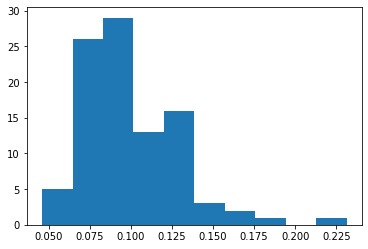

In [9]:
q_np = q.cpu().detach().numpy()
plt.hist(q_np[:, 0])

(array([26., 37., 13., 14.,  2.,  2.,  1.,  0.,  0.,  1.]),
 array([0.00950123, 0.05274342, 0.09598561, 0.13922781, 0.18247001,
        0.2257122 , 0.2689544 , 0.31219658, 0.35543877, 0.39868098,
        0.44192317], dtype=float32),
 <BarContainer object of 10 artists>)

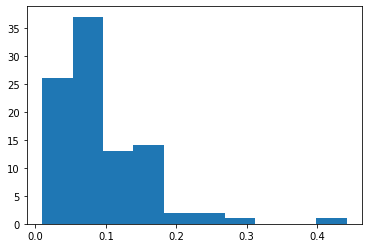

In [10]:
p_np = p.cpu().detach().numpy()
plt.hist(p_np[:, 0])